In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define the paths to your image folders
adequate_folder = '/kaggle/input/okradatasetfreshnessdetection/AdequateMature'
overmature_folder = '/kaggle/input/okradatasetfreshnessdetection/OverMature'

In [2]:
# Function to preprocess thermal images
def preprocess_thermal_image(image_path):
    # Load the thermal image
    image = cv2.imread(image_path)
    
    # Resize the image (InceptionV3 requires 299x299 input size)
    image_resized = cv2.resize(image, (299, 299))

    # Convert the image to grayscale for histogram equalization
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization to enhance image contrast
    image_eq = cv2.equalizeHist(image_gray)
    
    # Convert the equalized image back to BGR (3 channels) for RGB conversion
    image_eq_bgr = cv2.cvtColor(image_eq, cv2.COLOR_GRAY2BGR)
    
    # Convert image to RGB for the Inception model, as it's trained on RGB images
    image_rgb = cv2.cvtColor(image_eq_bgr, cv2.COLOR_BGR2RGB)
    
    return image_resized, image_rgb

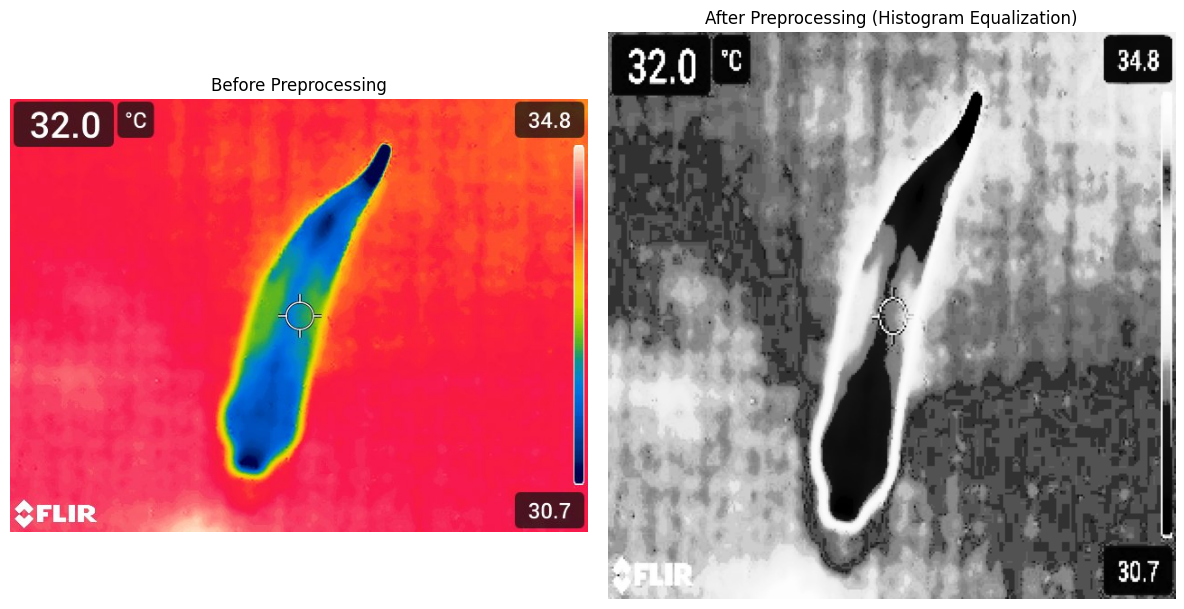

In [3]:
# Load thermal images from folders
adequate_image_paths = glob(os.path.join(adequate_folder, '*.jpg'))
overmature_image_paths = glob(os.path.join(overmature_folder, '*.jpg'))

# Preprocess images
adequate_images = [preprocess_thermal_image(img_path)[1] for img_path in adequate_image_paths]
overmature_images = [preprocess_thermal_image(img_path)[1] for img_path in overmature_image_paths]

# Show before and after preprocessing of an example image
sample_image_path = adequate_image_paths[0]
before, after = preprocess_thermal_image(sample_image_path)

# Plot before and after preprocessing
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(sample_image_path), cv2.COLOR_BGR2RGB))
plt.title("Before Preprocessing")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(after)
plt.title("After Preprocessing (Histogram Equalization)")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Prepare the labels (0 for adequate, 1 for overmature)
adequate_labels = [0] * len(adequate_images)
overmature_labels = [1] * len(overmature_images)

# Stack the data and labels
X = np.array(adequate_images + overmature_images)
y = np.array(adequate_labels + overmature_labels)

# Normalize images (InceptionV3 expects input to be scaled between -1 and 1)
X = X / 255.0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Load the InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom classification layers
model = Sequential()
model.add(base_model)  # Add the pre-trained base model
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

# Compile the model with the correct learning rate argument
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training data
datagen.fit(X_train)

# Train the model using augmented data
model.fit(datagen.flow(X_train, y_train_cat, batch_size=32),
          epochs=50,
          validation_data=(X_test, y_test_cat))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model (optional)
model.save('thermal_okra_classification_inceptionv3.h5')

# Example usage: Predict and display results on a test image
def predict_and_display(index):
    image = X_test[index]
    true_label = y_test[index]
    image_resized = cv2.resize(image, (299, 299))  # Resize for InceptionV3 input
    image_batch = np.expand_dims(image_resized, axis=0)  # Add batch dimension
    
    # Predict the class probabilities
    predicted_probs = model.predict(image_batch)
    predicted_label = np.argmax(predicted_probs)  # Get the predicted class
    
    # Display the image
    plt.imshow(image)
    plt.title(f"True Label: {'Adequate' if true_label == 0 else 'Overmature'} | "
              f"Predicted Label: {'Adequate' if predicted_label == 0 else 'Overmature'}")
    plt.axis('off')
    plt.show()

# Test the model with an image from the test set
predict_and_display(10)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.5076 - loss: 0.8736 - val_accuracy: 0.5366 - val_loss: 0.6595
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.6271 - loss: 0.6468 - val_accuracy: 0.7317 - val_loss: 0.5963
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.7368 - loss: 0.5581 - val_accuracy: 0.7805 - val_loss: 0.5114
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.7546 - loss: 0.5115 - val_accuracy: 0.7561 - val_loss: 0.4716
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.7793 - loss: 0.4957 - val_accuracy: 0.8293 - val_loss: 0.4378
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.8860 - loss: 0.3823 - val_accuracy: 0.8537 - val_loss: 0.4092
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.9197 - loss: 0.3318 - val_accuracy: 0.8293 - val_loss: 0.3774
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.8645 - loss: 0.3516 - val_accuracy: 0.9024 - val_loss: 0.3517
Epoch 9/50
6/6 ━━━━

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'X_test' and 'y_test' are the test data and true labels
# Predict probabilities for the test set
y_pred_prob = googlenet_model.predict(X_test)

# Convert probabilities to binary class labels (assuming binary classification)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()  # Adjust for binary classification

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print classification report for more detailed analysis
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Adequate', 'Overmature'], yticklabels=['Adequate', 'Overmature'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'googlenet_model' is not defined